#### Задание - Обучите нейронную сеть любой архитектуры на каком-то производственном датасете. Сделайте анализ того, что вам помогло в улучшения работы нейронной сети.

- для решения задачи используем датасет Северстали /severstal-steel-defect-detection/

#### Этап 1. Подготовка окружения

In [39]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [40]:
# Загрузка датаасета
dataset_path = "data/sample_submission.csv"
df = pd.read_csv(dataset_path)

In [41]:
# Просмотр структуры
print("Dataset shape:", df.shape)
print("Columns:", df.columns)
print("First few rows:")
print(df.head())

Dataset shape: (5506, 3)
Columns: Index(['ImageId', 'EncodedPixels', 'ClassId'], dtype='object')
First few rows:
         ImageId EncodedPixels  ClassId
0  0000f269f.jpg      1 409600        0
1  000ccc2ac.jpg      1 409600        0
2  002451917.jpg      1 409600        0
3  003c5da97.jpg      1 409600        0
4  0042e163f.jpg      1 409600        0


#### Этап 2: Обработка данных

In [42]:
# предварительная обработка данных
data_folder = "data"
train_csv_path = os.path.join(data_folder, "train.csv")
train_images_folder = os.path.join(data_folder, "train_images")

In [43]:
# загрузка .csv файла
train_df = pd.read_csv(train_csv_path)
# обаботка данных в том  числе уменьшение выборки
train_df_sample = train_df.sample(n=1000, random_state=42) 

In [44]:
# подготова данных для передачи

# определение функцию для чтения
def load_and_preprocess_image(image_id):
    image_path = os.path.join(train_images_folder, image_id)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = cv2.resize(image, (224, 224))  # Resize to desired dimensions
    image = image / 255.0  # Normalize pixel values
    return image

# загрузка  изображеений
X = np.array([load_and_preprocess_image(image_id) for image_id in train_df_sample['ImageId']])
y = train_df_sample['ClassId'].values


In [45]:
# Разделение данных на обучающие и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# проверка тестовых и обучающих выборок
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (800, 224, 224, 3)
X_test shape: (200, 224, 224, 3)
y_train shape: (800,)
y_test shape: (200,)


#### Этап 3: Создание модели

In [47]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [48]:
# загрузка  предобученной модели
pretrained_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [49]:
# создание модели
model = Sequential()

In [50]:
# добавление предобученной модели ResNet50
model.add(pretrained_model)

In [51]:
# глобальный средний слой
model.add(GlobalAveragePooling2D())

In [52]:
# выходной слой
model.add(Dense(4, activation='softmax'))  # Assuming there are 4 classes

In [53]:
# заморозка предварительно обученных слоев
for layer in pretrained_model.layers:
    layer.trainable = False

In [54]:
# компиляция модели
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [55]:
# сводка по модели
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

#### Этап 4: Обучение модели

In [57]:
#значения меток в дата сете начинаются с 0
y_train -= 1
y_test -= 1

# обучение на подготовленных данных
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.4517 - loss: 1.3547 - val_accuracy: 0.7450 - val_loss: 0.8582
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.7319 - loss: 0.8690 - val_accuracy: 0.7450 - val_loss: 0.8225
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.7651 - loss: 0.7877 - val_accuracy: 0.7450 - val_loss: 0.8334
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.7628 - loss: 0.7824 - val_accuracy: 0.7450 - val_loss: 0.8216
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.7627 - loss: 0.7911 - val_accuracy: 0.7450 - val_loss: 0.8326
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.7416 - loss: 0.8377 - val_accuracy: 0.7450 - val_loss: 0.8391
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.7651 - loss: 0.7909 - val_accuracy: 0.7450 - val_loss: 0.8218
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.7634 - loss: 0.7894 - val_accuracy: 0.7450 - val_loss:

In [58]:
# оценка процесса обучения
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Training Loss: 0.8240540027618408
Training Accuracy: 0.7400000095367432
Test Loss: 0.8202813863754272
Test Accuracy: 0.7450000047683716


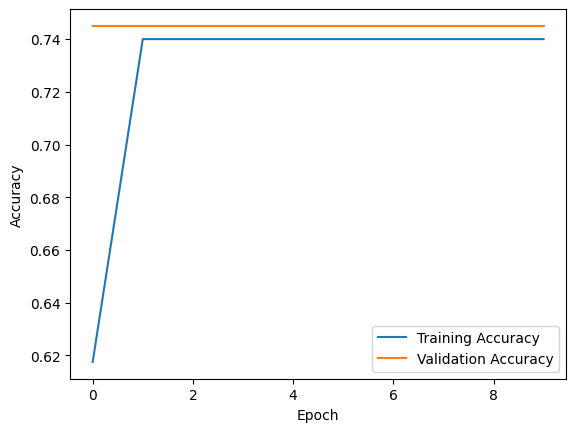

In [59]:
# точность проверки по эпохам
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

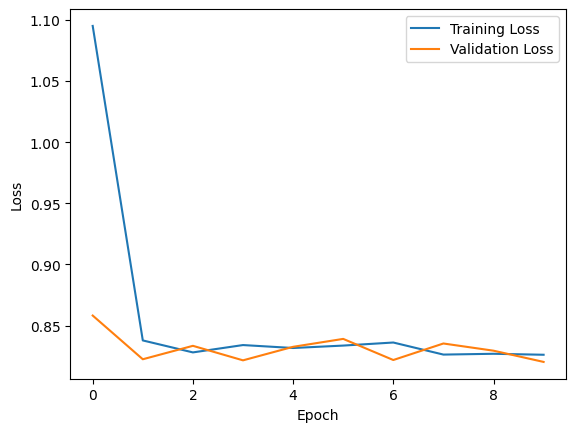

In [60]:
# график потерь по эпохам
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Этап 5: Анализ результатов и выводы ###

In [61]:
# 1. Оценим производительность нейросети на тестовой выборке
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Test Loss: 0.8202813863754272
Test Accuracy: 0.7450000047683716


### На основании результатов оценки, нейронная сеть достигла тестовой потери около 0,82 и тестовой точности примерно 74,5%. Это свидетельствует о том, что модель вполне хорошо справляется с классификацией дефектов на изображениях стали из набора данных Северстали.

#### Однако есть место для улучшений. Дальнейший анализ кривых обучения и валидации может раскрыть проблемы с переобучением или недообучением. Кроме того, эксперименты с различными архитектурами, гиперпараметрами могут улучшить производительность модели.

 #### В заключение, хотя текущая модель демонстрирует приемлемую производительность, существуют возможности для улучшения с целью достижения еще более высокой точности и надежности в обнаружении дефектов. Последующая оптимизация может привести к дальнейшему улучшению качества и эффективности модели.